MEG sensor level analysis code for the project of "dynamic flow";
24th Oct by Bohao;
Steps of code:
1.Import data, plot data and check;
2.extract the head position, check it and filter it;
3.calculate average head position (ss level)
4.Max-filter to remove big artifacts;
5.Band pass filering, plot data and do annotations on bad segments;
6.Load SSS-and-annotated data and check PSD plots;
7.Check triggers;
8.Concatenate three SSS-and-annotated data files;
9.Load concatenated data and compute ICA;
10.Apply ICA and check the ICA-ed data;
11.Load ICA-ed data and Segment data;
12.Plot ERF for each type of sounds;
13.Calculating significant sensors with permutation test;
14.View the significant sensors on topography;
15.View the significant sensors on surface (with sMRI data)


In [8]:
import mne
import os
import numpy as np
import picard
mne.viz.set_browser_backend('qt')
from mne import annotations_from_events
import matplotlib.pyplot as plt
from mne.stats import permutation_t_test
from mne.preprocessing import maxwell_filter
from pathlib import Path

In [19]:
# 1. import data, plot data and check, select bad channels
data_dir = Path("D:/Ph.D/11_unige/MEG/")# change this for your computer
subject         = 'test'
meg_file = data_dir / "MEGdata" / subject / "test_pilot_nodevice.fif" #only perform oddball task
raw = mne.io.read_raw_fif(meg_file, preload=True)
calibration = data_dir / "MEGdata" / "neededfile" / "sss_cal.dat" # file from FCBG
cross_talk = data_dir / "MEGdata" / "neededfile" / "ct_sparse.fif" # file from FCBG
auto_noisy_chs, auto_flat_chs=mne.preprocessing.find_bad_channels_maxwell(raw, calibration=calibration, cross_talk=cross_talk)
print(auto_noisy_chs) 
print(auto_flat_chs)
raw.plot()

Opening raw data file D:\Ph.D\11_unige\MEG\MEGdata\test\test_pilot_nodevice.fif...
    Read a total of 17 projection items:
        ssp_combined_0_68deg (1 x 306)  idle
        ssp_combined_1_68deg (1 x 306)  idle
        ssp_combined_2_68deg (1 x 306)  idle
        ssp_combined_3_68deg (1 x 306)  idle
        ssp_combined_4_68deg (1 x 306)  idle
        ssp_combined_5_68deg (1 x 306)  idle
        ssp_combined_6_68deg (1 x 306)  idle
        ssp_combined_7_68deg (1 x 306)  idle
        ssp_combined_8_68deg (1 x 306)  idle
        ssp_combined_9_68deg (1 x 306)  idle
        ssp_combined_10_68deg (1 x 306)  idle
        ssp_combined_11_68deg (1 x 306)  idle
        ssp_combined_12_68deg (1 x 306)  idle
        ssp_combined_13_68deg (1 x 306)  idle
        ssp_combined_14_68deg (1 x 306)  idle
        ssp_combined_15_68deg (1 x 306)  idle
        ssp_combined_16_68deg (1 x 306)  idle
    Range : 12000 ... 230999 =     12.000 ...   230.999 secs
Ready.
Reading 0 ... 218999  =      0.000 .

C:\Users\Bohao Tian\AppData\Local\Temp\ipykernel_28240\724199451.py:5: RuntimeWarning: This filename (D:\Ph.D\11_unige\MEG\MEGdata\test\test_pilot_nodevice.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(meg_file, preload=True)


D:\Ph.D\11_unige\MEG\MEGdata\neededfile\sss_cal.dat
D:\Ph.D\11_unige\MEG\MEGdata\neededfile\ct_sparse.fif
Applying low-pass filter with 40.0 Hz cutoff frequency ...
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 331 samples (0.331 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.8s


Scanning for bad channels in 43 intervals (5.0 s) ...


[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    1.5s


    No bad MEG channels
    Processing 204 gradiometers and 102 magnetometers
    Using fine calibration sss_cal.dat
        Adjusting non-orthogonal EX and EY
        Adjusted coil positions by (μ ± σ): 0.4° ± 0.4° (max: 2.0°)
    Automatic origin fit: head of radius 90.5 mm
    Using origin -1.1, 6.5, 42.7 mm in the head frame
        Interval   1:    0.000 -    4.999
        Interval   2:    5.000 -    9.999
        Interval   3:   10.000 -   14.999
        Interval   4:   15.000 -   19.999
        Interval   5:   20.000 -   24.999
        Interval   6:   25.000 -   29.999
        Interval   7:   30.000 -   34.999
        Interval   8:   35.000 -   39.999
        Interval   9:   40.000 -   44.999
        Interval  10:   45.000 -   49.999
        Interval  11:   50.000 -   54.999
        Interval  12:   55.000 -   59.999
        Interval  13:   60.000 -   64.999
        Interval  14:   65.000 -   69.999
        Interval  15:   70.000 -   74.999
        Interval  16:   75.000 -   79.9

Channels marked as bad:
none


In [ ]:
# 2. extract the head position, check it and filter it
# （don't have data now）
chpi_amplitudes = mne.chpi.compute_chpi_amplitudes(raw)
chpi_locs = mne.chpi.compute_chpi_locs(raw.info, chpi_amplitudes)
head_pos = mne.chpi.compute_head_pos(raw.info, chpi_locs)
mne.viz.plot_head_positions(
    head_pos, mode="traces", destination=raw.info["dev_head_t"], info=raw.info
)
raw = mne.chpi.filter_chpi(raw)

In [ ]:
# 3. calculate average head position
# (don't have data now)
# (load the three raw recordings for each participant as raw1, raw2, and raw3)
raws=[raw1, raw2, raw3]
average_dev_head_t = mne.preprocessing.compute_average_dev_head_t(raws)
del raws, raw1, raw2, raw3

In [20]:
# 4. Max-filter to remove big artifacts (with cHPI)
if raw.info['proc_history'] == []:
    head_pos = None # from the step 2, for now we don't have
    calibration = data_dir / "MEGdata" / "neededfile" / "sss_cal.dat" # file from FCBG
    cross_talk = data_dir / "MEGdata" / "neededfile" / "ct_sparse.fif" # file from FCBG
    raw_filtered = maxwell_filter(raw, calibration=calibration, cross_talk=cross_talk, extended_proj=(raw.info["projs"])) # change to the next line if have cHPI data
    #raw_filtered = maxwell_filter(raw, calibration=calibration, cross_talk=cross_talk, destination=average_dev_head_t,head_pos=head_pos, extended_proj=(raw.info["projs"]))
del raw
raw=raw_filtered
raw.plot()

Maxwell filtering raw data
    No bad MEG channels
    Processing 204 gradiometers and 102 magnetometers
    Extending external SSS basis using 17 projection vectors
    Using fine calibration sss_cal.dat
        Adjusting non-orthogonal EX and EY
        Adjusted coil positions by (μ ± σ): 0.4° ± 0.4° (max: 2.0°)
    Automatic origin fit: head of radius 90.5 mm
    Using origin -1.1, 6.5, 42.7 mm in the head frame
        Using 104/112 harmonic components for    0.000  (72/80 in, 32/32 out)
    Using loaded raw data
    Processing 21 data chunks
[done]


Channels marked as bad:
none


In [21]:
# 5. Band pass filering, plot data and do annotations on bad segments (with the label "bad", check the butterfly plot)
raw.filter(0.5, 40.0)
raw.plot()

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 6601 samples (6.601 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    1.2s


Waiting for Loading-Thread to finish... (max. 10 sec)
Channels marked as bad:
none


In [22]:
# 5.1 save the SSS-and-annotated data
dir_name, file_name = os.path.split(raw.filenames[0])
base_name, ext = os.path.splitext(file_name)
new_file_name = f"{base_name}_annotated{ext}"
save_path = os.path.join(dir_name, new_file_name)
raw.save(save_path, overwrite=True)

Overwriting existing file.
Writing D:\Ph.D\11_unige\MEG\MEGdata\test\test_pilot_nodevice_annotated.fif


C:\Users\Bohao Tian\AppData\Local\Temp\ipykernel_28240\4066163037.py:6: RuntimeWarning: This filename (D:\Ph.D\11_unige\MEG\MEGdata\test\test_pilot_nodevice_annotated.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(save_path, overwrite=True)


Closing D:\Ph.D\11_unige\MEG\MEGdata\test\test_pilot_nodevice_annotated.fif
[done]


Opening raw data file D:/Ph.D/11_unige/MEG//MEGdata/test/test_pilot_nodevice_annotated.fif...
    Range : 12000 ... 230999 =     12.000 ...   230.999 secs
Ready.
Reading 0 ... 218999  =      0.000 ...   218.999 secs...


C:\Users\Bohao Tian\AppData\Local\Temp\ipykernel_28240\3507404030.py:5: RuntimeWarning: This filename (D:/Ph.D/11_unige/MEG//MEGdata/test/test_pilot_nodevice_annotated.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(meg_file, preload=True)


Effective window size : 2.048 (s)


c:\Users\Bohao Tian\AppData\Local\Programs\Python\Python38\lib\site-packages\mne\viz\utils.py:165: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


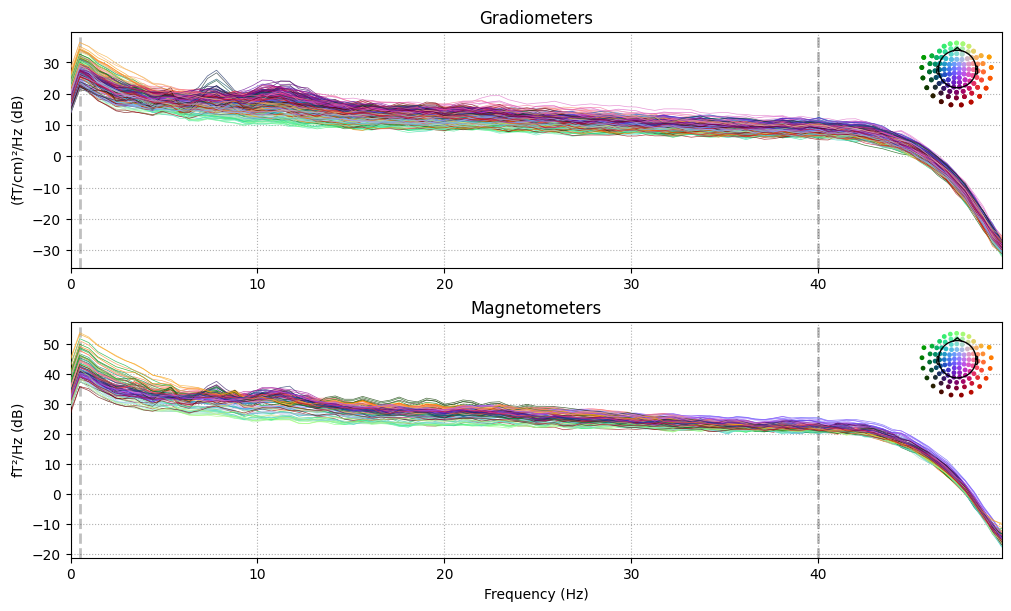

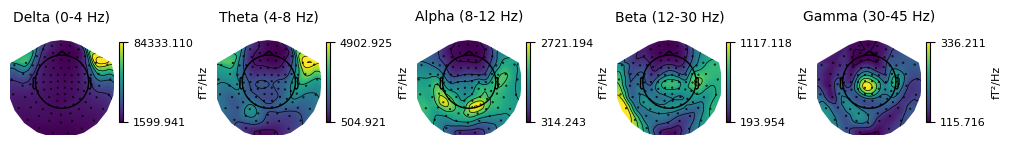

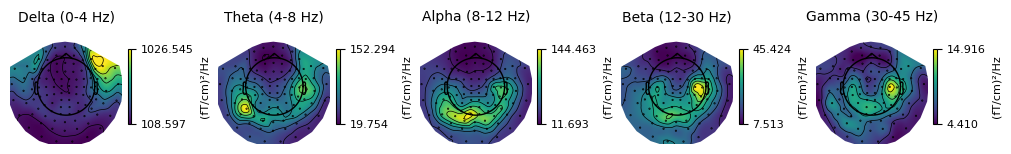

In [24]:
# 6. Load SSS-and-annotated data and check PSD plots 
data_dir = Path("D:/Ph.D/11_unige/MEG/")# change this for your computer
subject         = 'test'
meg_file = data_dir / "MEGdata" / subject / "test_pilot_nodevice_annotated.fif" 
raw = mne.io.read_raw_fif(meg_file, preload=True)
psd_raw  = raw.compute_psd(fmax=50)
psd_raw.plot(xscale='linear')
bands = {'Delta (0-4 Hz)': (0, 4), 'Theta (4-8 Hz)': (4, 8),
         'Alpha (8-12 Hz)': (8, 12), 'Beta (12-30 Hz)': (12, 30),
         'Gamma (30-45 Hz)': (30, 45)}
for ch_type in set(['eeg','mag','grad']).intersection(np.unique(raw.get_channel_types()).tolist()):
    psd_raw.plot_topomap(bands=bands, ch_type=ch_type, cmap='viridis')

200 events found on stim channel STI102
Event IDs: [16 32 64]


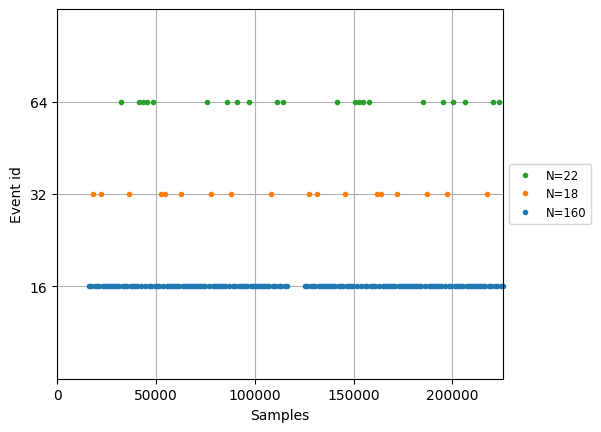

Waiting for Loading-Thread to finish... (max. 10 sec)
Channels marked as bad:
none


In [25]:
# 7. Check events (triggers)
events = mne.find_events(raw, stim_channel="STI102")
mne.viz.plot_events(events, first_samp=0, equal_spacing=True, show=True)   
raw.plot(
    events=events,
    event_color={16: "r", 32: "g", 64: "b"},
)  

In [ ]:
# 8. Concatenate three data files
# (now we don't have)
# (load the three SSS-and-annotated data for each participant as data1, data2, and data3)
datas=[data1, data2, data3]
raw_combined = mne.concatenate_raws(datas)
del datas, data1, data2, data3
raw=raw_combined

<ICA | no decomposition, method: picard>
Fitting ICA to data using 306 channels (please be patient, this may take a while)
Selecting by number: 30 components
Fitting ICA took 37.6s.
<ICA | raw data decomposition, method: picard (fit in 208 iterations on 219000 samples), 30 ICA components (306 PCA components available), channel types: mag, grad, no sources marked for exclusion>


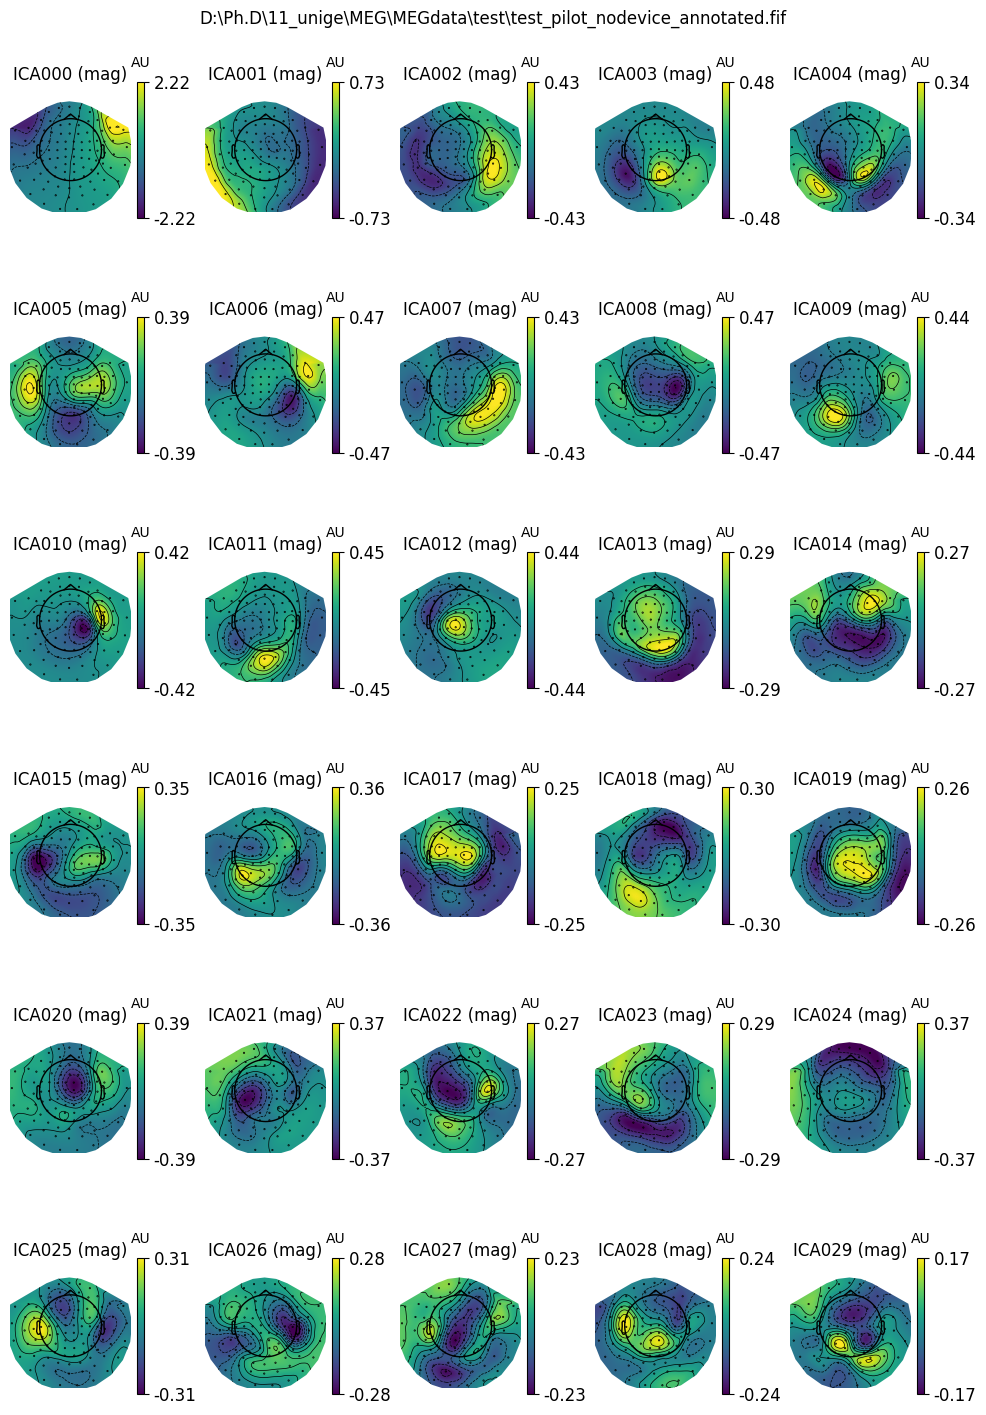

Creating RawArray with float64 data, n_channels=30, n_times=219000
    Range : 12000 ... 230999 =     12.000 ...   230.999 secs
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (30 components)
    Zeroing out 2 ICA components
    Projecting back using 306 PCA components


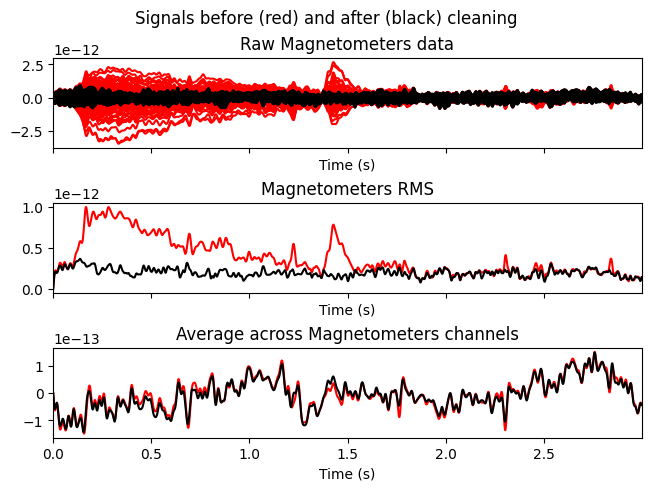

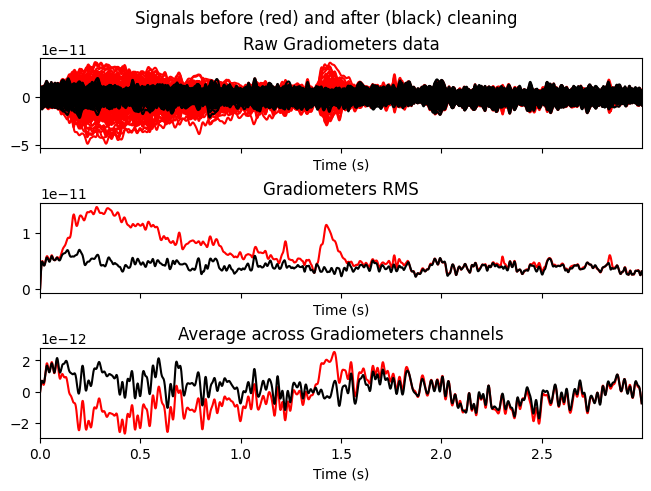

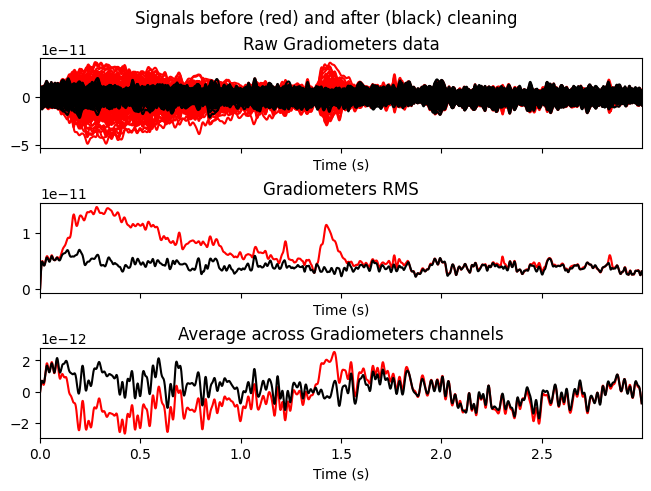

In [26]:
# 9. Computing ICAs
# load concatenated data (for now we don't have)
percentcut_bothside, n_components, method, decim = 5, 30, 'picard', 1
ica = mne.preprocessing.ICA(n_components=n_components, method=method)
print(ica)
ica.fit(raw, decim=decim)
print(ica)
ica.plot_components(picks=range(0, ica.n_components_), ch_type=None, res=64, 
              cmap='viridis', sensors=True, colorbar=True, title=raw.filenames[0].split('/')[-1], show=True, 
              outlines='head', contours=8, image_interp='cubic', inst=None)  
ica.plot_sources(raw, block=True)
ica.plot_overlay(raw)

Components to Exclude = [0, 1]
<ICA | raw data decomposition, method: picard (fit in 208 iterations on 219000 samples), 30 ICA components (306 PCA components available), channel types: mag, grad, 2 sources marked for exclusion>
Applying ICA to Raw instance
    Transforming to ICA space (30 components)
    Zeroing out 2 ICA components
    Projecting back using 306 PCA components
Effective window size : 2.048 (s)


c:\Users\Bohao Tian\AppData\Local\Programs\Python\Python38\lib\site-packages\mne\viz\utils.py:165: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


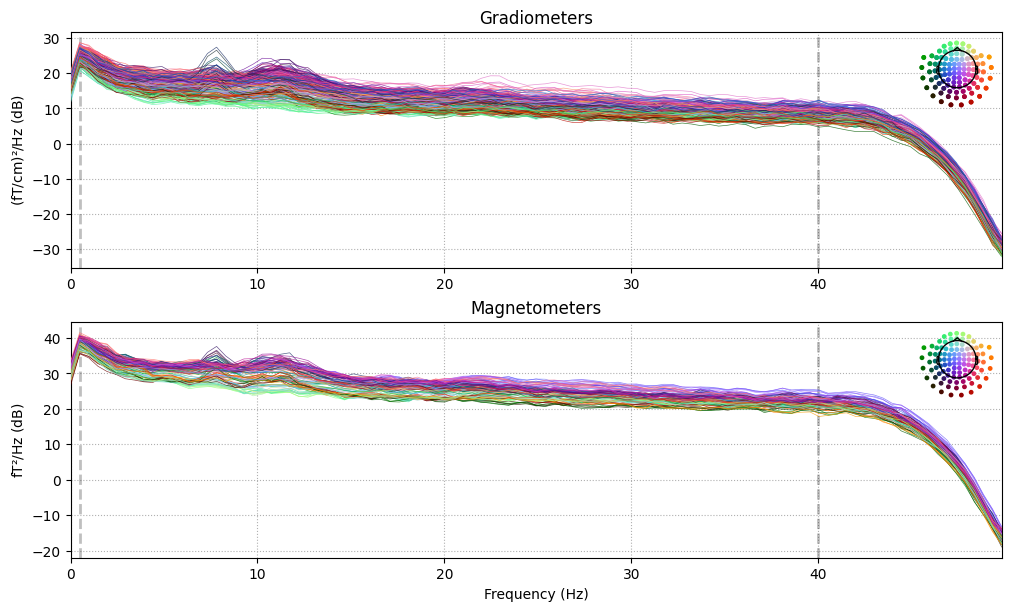

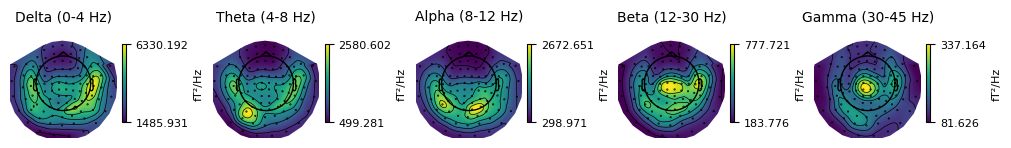

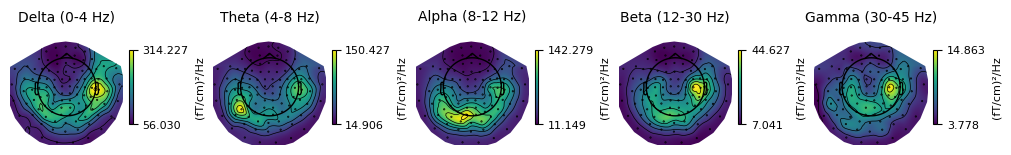

Channels marked as bad:
none


In [27]:
# 10. Apply ICA and check the ICA-ed data
print("Components to Exclude = %s" % ica.exclude)
print(ica)
ica.apply(raw)
raw.plot()
psd_raw  = raw.compute_psd(fmax=50)
psd_raw.plot(xscale='linear')
bands = {'Delta (0-4 Hz)': (0, 4), 'Theta (4-8 Hz)': (4, 8),
         'Alpha (8-12 Hz)': (8, 12), 'Beta (12-30 Hz)': (12, 30),
         'Gamma (30-45 Hz)': (30, 45)}
for ch_type in set(['eeg','mag','grad']).intersection(np.unique(raw.get_channel_types()).tolist()):
    psd_raw.plot_topomap(bands=bands, ch_type=ch_type, cmap='viridis')

In [28]:
# 10.1 save ICA-ed data
dir_name, file_name = os.path.split(raw.filenames[0])
base_name, ext = os.path.splitext(file_name)
new_file_name = f"{base_name}_ICAed{ext}"
save_path = os.path.join(dir_name, new_file_name)
raw.save(save_path, overwrite=True)

Overwriting existing file.
Writing D:\Ph.D\11_unige\MEG\MEGdata\test\test_pilot_nodevice_annotated_ICAed.fif


C:\Users\Bohao Tian\AppData\Local\Temp\ipykernel_28240\1115595427.py:6: RuntimeWarning: This filename (D:\Ph.D\11_unige\MEG\MEGdata\test\test_pilot_nodevice_annotated_ICAed.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(save_path, overwrite=True)


Closing D:\Ph.D\11_unige\MEG\MEGdata\test\test_pilot_nodevice_annotated_ICAed.fif
[done]


In [29]:
# 11. Load ICA-ed data and Segment data (with baseline correction)
data_dir = Path("D:/Ph.D/11_unige/MEG/")# change this for your computer
subject         = 'test'
meg_file = data_dir / "MEGdata" / subject / "test_pilot_nodevice_annotated_ICAed.fif" # the ICA-ed data file
raw = mne.io.read_raw_fif(meg_file, preload=True)
events = mne.find_events(raw, stim_channel="STI102")
event_id = {
    "auditory/standard": 16,
    "auditory/target": 32,
    "auditory/novel": 64,
}
epochs = mne.Epochs(
    raw, events, event_id, tmin=-0.2, tmax=0.6, baseline=(-0.2, 0), picks="meg", preload=True
)

Opening raw data file D:\Ph.D\11_unige\MEG\MEGdata\test\test_pilot_nodevice_annotated_ICAed.fif...
    Range : 12000 ... 230999 =     12.000 ...   230.999 secs
Ready.
Reading 0 ... 218999  =      0.000 ...   218.999 secs...


C:\Users\Bohao Tian\AppData\Local\Temp\ipykernel_28240\2328898048.py:5: RuntimeWarning: This filename (D:\Ph.D\11_unige\MEG\MEGdata\test\test_pilot_nodevice_annotated_ICAed.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(meg_file, preload=True)


200 events found on stim channel STI102
Event IDs: [16 32 64]
Not setting metadata
200 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 200 events and 801 original time points ...
0 bad epochs dropped


No projector specified for this dataset. Please consider the method self.add_proj.


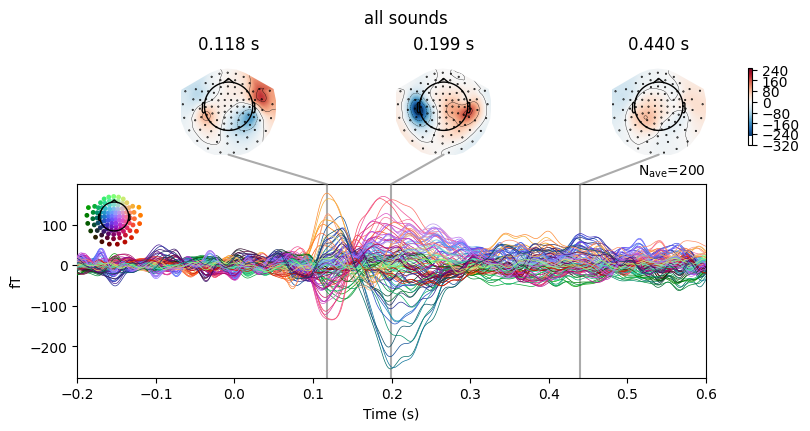

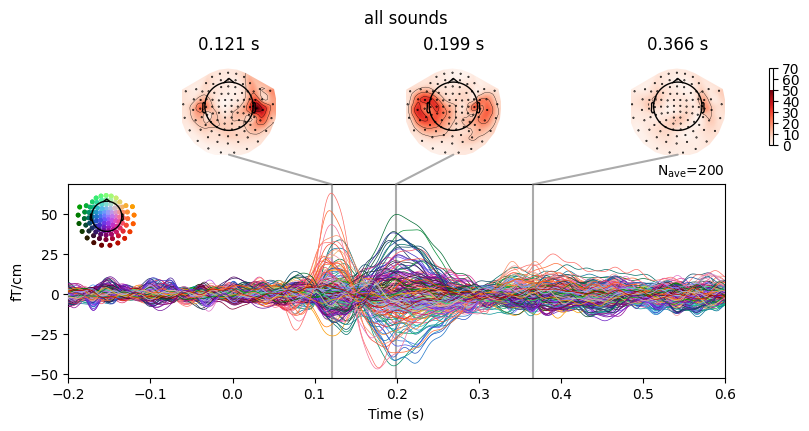

No projector specified for this dataset. Please consider the method self.add_proj.


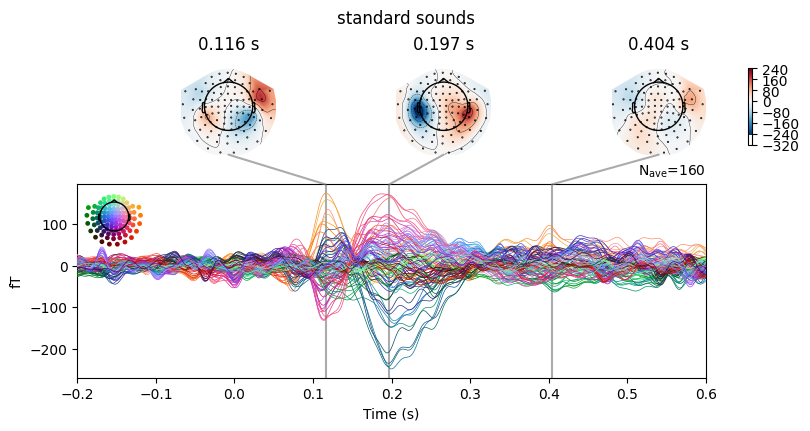

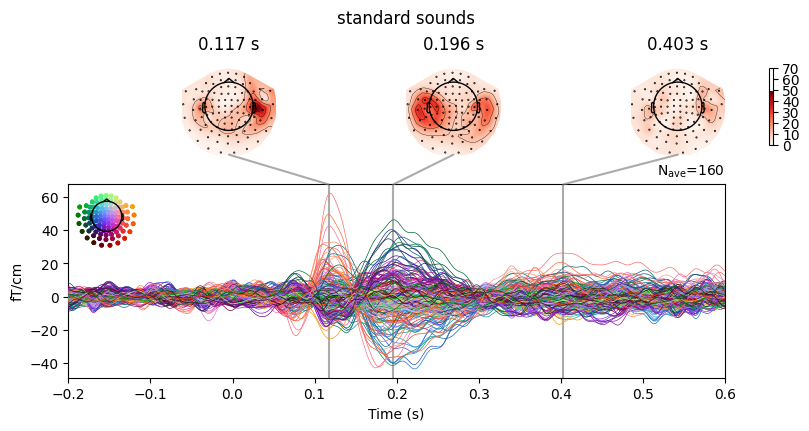

No projector specified for this dataset. Please consider the method self.add_proj.


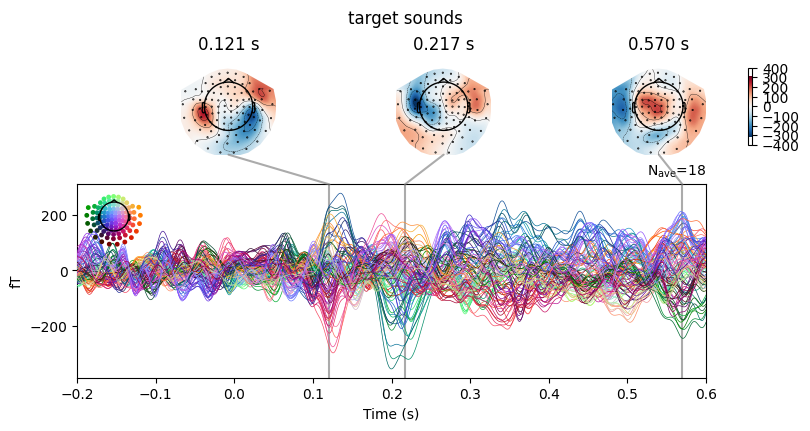

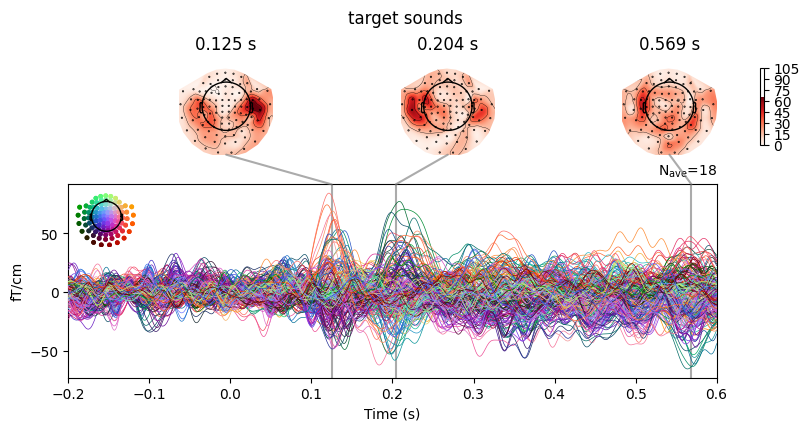

No projector specified for this dataset. Please consider the method self.add_proj.


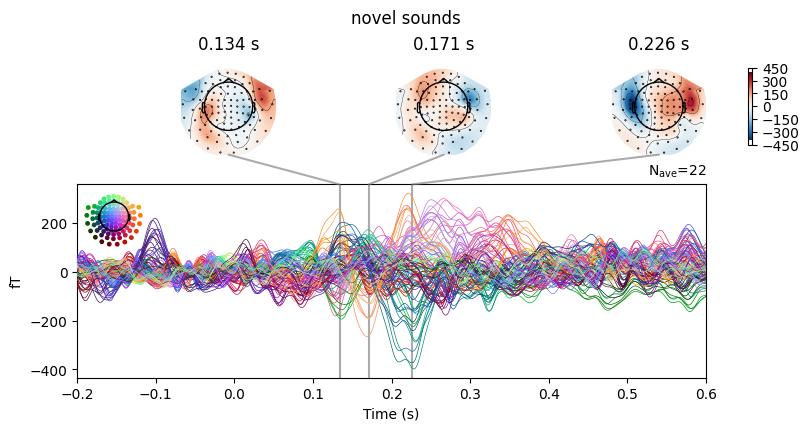

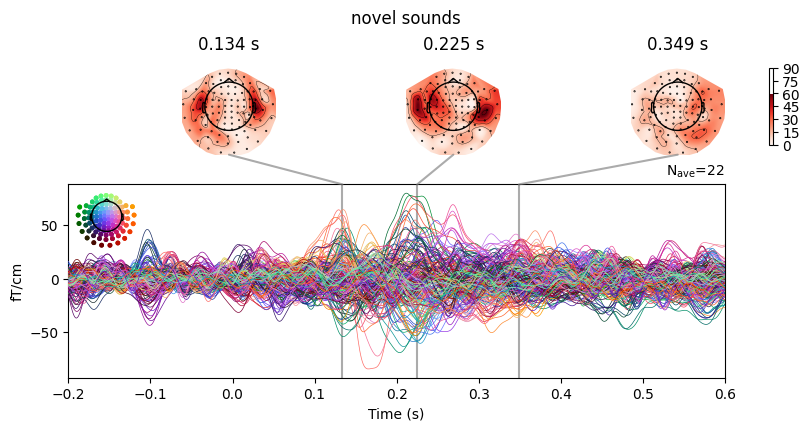

[<Figure size 800x420 with 6 Axes>, <Figure size 800x420 with 6 Axes>]

In [30]:
# 12. Plot ERF for each type of sounds and all the sounds
epochs["auditory"].average().plot_joint(title="all sounds")
epochs["auditory/standard"].average().plot_joint(title="standard sounds")
epochs["auditory/target"].average().plot_joint(title="target sounds")
epochs["auditory/novel"].average().plot_joint(title="novel sounds")

In [31]:
# 13. Calculating significant sensors with permutation test
# pick MEG Gradiometers
event_id = {
    "auditory/standard": 16,
    "auditory/target": 32,
    "auditory/novel": 64,
} #all the types of sounds
picks = mne.pick_types(raw.info, meg='grad',exclude='bads')  
epochs = mne.Epochs(raw, events, event_id, tmin=-0.2, tmax=0.6, picks=picks,
                    baseline=(None, 0), reject=dict(grad=4000e-13))
data = epochs.get_data()
times = epochs.times
temporal_mask = np.logical_and(0.1 <= times, times <= 0.2) # important: change time window here to see specific duration of interest
data = np.mean(data[:, :, temporal_mask], axis=2)
n_permutations = 50000
T0, p_values, H0 = permutation_t_test(data, n_permutations, n_jobs=None)
significant_sensors = picks[p_values <= 0.05]
significant_sensors_names = [raw.ch_names[k] for k in significant_sensors]
print("Number of significant sensors : %d" % len(significant_sensors))
print("Sensors names : %s" % significant_sensors_names)

Not setting metadata
200 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 200 events and 801 original time points ...
0 bad epochs dropped
Permuting 49999 times...
Number of significant sensors : 21
Sensors names : ['MEG0132', 'MEG0222', 'MEG0223', 'MEG0232', 'MEG0322', 'MEG0342', 'MEG0343', 'MEG0413', 'MEG1223', 'MEG1323', 'MEG1333', 'MEG1423', 'MEG1433', 'MEG1512', 'MEG1523', 'MEG1612', 'MEG1623', 'MEG2622', 'MEG2623', 'MEG2632', 'MEG2643']


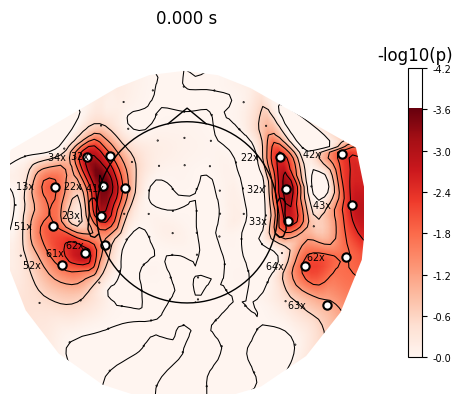

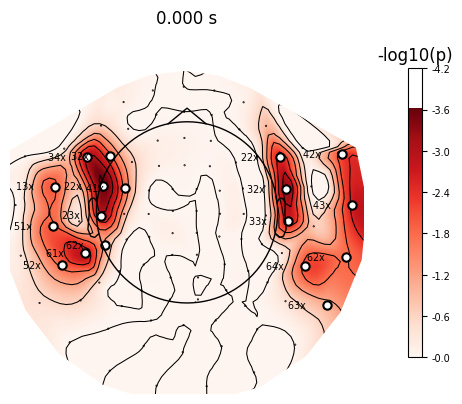

In [32]:
# 14. View the significant sensors on topography
evoked = mne.EvokedArray(-np.log10(p_values)[:, np.newaxis],
                         epochs.info, tmin=0.)
# Extract mask and indices of active sensors in the layout
stats_picks = mne.pick_channels(evoked.ch_names, significant_sensors_names)
mask = p_values[:, np.newaxis] <= 0.05
evoked.plot_topomap(ch_type='grad', times=[0], scalings=1,
                    time_format=None, cmap='Reds', vlim=(0., np.max),
                    units='-log10(p)', cbar_fmt='-%0.1f', mask=mask,
                    size=3, show_names=lambda x: x[4:] + ' ' * 20,
                    time_unit='s')

In [ ]:
# 15. View the significant sensors on surface (with sMRI data)